## Importing Libraries and Tools

In [124]:

# from matplotlib import style
# %matplotlib inline
# plt.style.use('ggplot')
# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.formula.api import ols
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearRegression
# import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

## Importing CSV from Kaggle

In [70]:
# https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

df = pd.read_csv(('bigml_59c28831336c6604c800002a.csv'), index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   float6

## Introduction

During this project, I want to understand what factors are most important in understanding how to retain a customer with Telecom based on this CSV file. The features are pretty understandable so I won't go into depth on describing them.

My predictor to these models, I will be using the 'churn' feature. This feature states whether or not the customer stayed or left the phone carrier.

Questions to answer during project:

  1) How heavily will customer service calls effect if a customer stays or leaves the provider?
  2) Will higher account length retain the customer better?
  3) What is the most accurate model at predicting accurately if a customer is churned or not.

## EDA/Cleaning

In [71]:
# Dropping irrelevent information to model. 
# This information will not help predict if a customer is retained or not.

df = df.drop('area code', 1)
df = df.drop('phone number', 1)

In [72]:
# There is a distinct imbalance that needs to be addressed during the training section of Train-Test Split. 
# The model would unfairly have a high accuracy score of predicting false
# but poorly predict accuracy of new data entering the model.

df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

### Dummy Variable Creation

In [73]:
# Creating dummy variables for three columns that were either True/False or Yes/No

international_plan = pd.get_dummies(df['international plan'], prefix = 'international plan', drop_first = True)
voice_mail_plan = pd.get_dummies(df['voice mail plan'], prefix = 'voice mail plan', drop_first = True)
churned = pd.get_dummies(df['churn'], prefix = 'churn', drop_first = True)

In [74]:
international_plan.columns = [column.replace('.', '_') for column in international_plan.columns]

In [75]:
voice_mail_plan.columns = [column.replace('.', '_') for column in voice_mail_plan.columns]

In [76]:
churned.columns = [column.replace('.', '_') for column in churned.columns]

In [77]:
voice_mail_plan.columns

Index(['voice mail plan_yes'], dtype='object')

In [78]:
international_plan = international_plan.astype(str).astype(float)
voice_mail_plan = voice_mail_plan.astype(str).astype(float)
churned = churned.astype(str).astype(float)

In [79]:
# Verifying international plan_yes and the others changed their Dtype
# to effectively utilize predictive modeling later on

international_plan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan_yes  3333 non-null   float64
dtypes: float64(1)
memory usage: 52.1+ KB


In [80]:
# Adding and subtracting dummy columns and columns that they represented

df = pd.concat([df, international_plan, voice_mail_plan, churned], axis = 1)
df

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,international plan_yes,voice mail plan_yes,churn_True
state,,,,,,,,,,,,,,,,,,,,,
KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0.0,1.0,0.0
OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0.0,1.0,0.0
NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0.0,0.0,0.0
OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1.0,0.0,0.0
OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ,192,no,yes,36,156.2,77,26.55,215.5,126,18.32,...,83,12.56,9.9,6,2.67,2,False,0.0,1.0,0.0
WV,68,no,no,0,231.1,57,39.29,153.4,55,13.04,...,123,8.61,9.6,4,2.59,3,False,0.0,0.0,0.0
RI,28,no,no,0,180.8,109,30.74,288.8,58,24.55,...,91,8.64,14.1,6,3.81,2,False,0.0,0.0,0.0


In [81]:
df = df.drop(['international plan', 'voice mail plan', 'churn'], axis=1)

In [82]:
df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
state,,,,,,,,,,,,,,,,,,
KS,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0,1.0,0.0
OH,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0,1.0,0.0
NJ,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0,0.0,0.0
OH,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1.0,0.0,0.0
OK,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1.0,0.0,0.0


### Exploratory Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d004f3c8>,
      dtype=object)

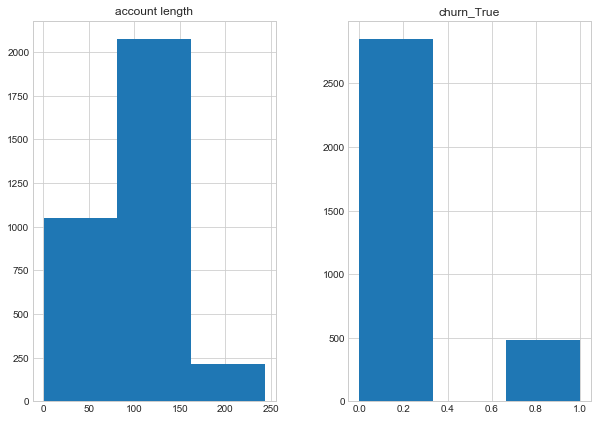

In [119]:
acct_length_vs_churn = ['account length', 'churn_True']
df[acct_length_vs_churn].hist(bins=3, figsize=(10, 7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5cff01d30>,
      dtype=object)

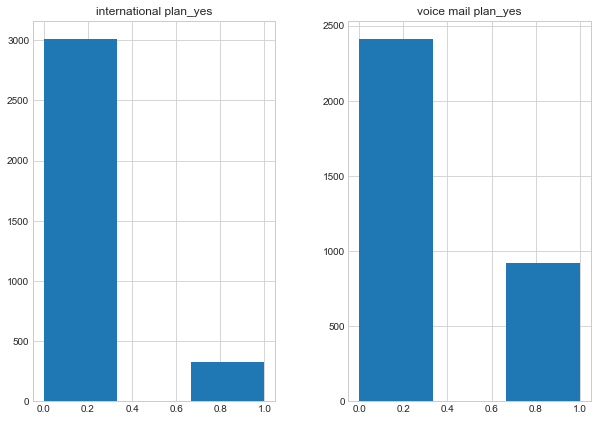

In [118]:
plans = ['international plan_yes', 'voice mail plan_yes']
df[plans].hist(bins=3, figsize=(10, 7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d54864e0>,
      dtype=object)

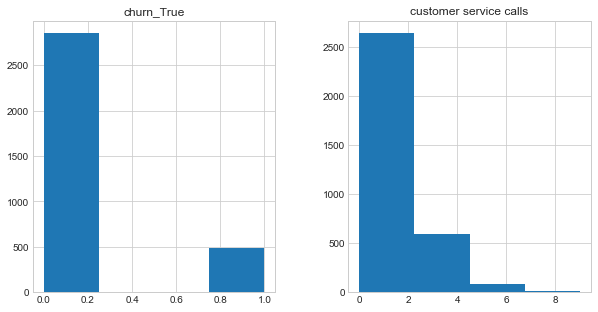

In [117]:
cs_call_vs_churn = ['customer service calls', 'churn_True']
df[cs_call_vs_churn].hist(bins=4, figsize=(10, 5))

In [106]:
total_minutes = ['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes']
df[total_minutes].describe()

,total day minutes,total eve minutes,total night minutes,total intl minutes
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,179.775098,200.980348,200.872037,10.237294
std,54.467389,50.713844,50.573847,2.791840
min,0.000000,0.000000,23.200000,0.000000
25%,143.700000,166.600000,167.000000,8.500000
50%,179.400000,201.400000,201.200000,10.300000
75%,216.400000,235.300000,235.300000,12.100000
max,350.800000,363.700000,395.000000,20.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d35e3b70>,
      dtype=object)

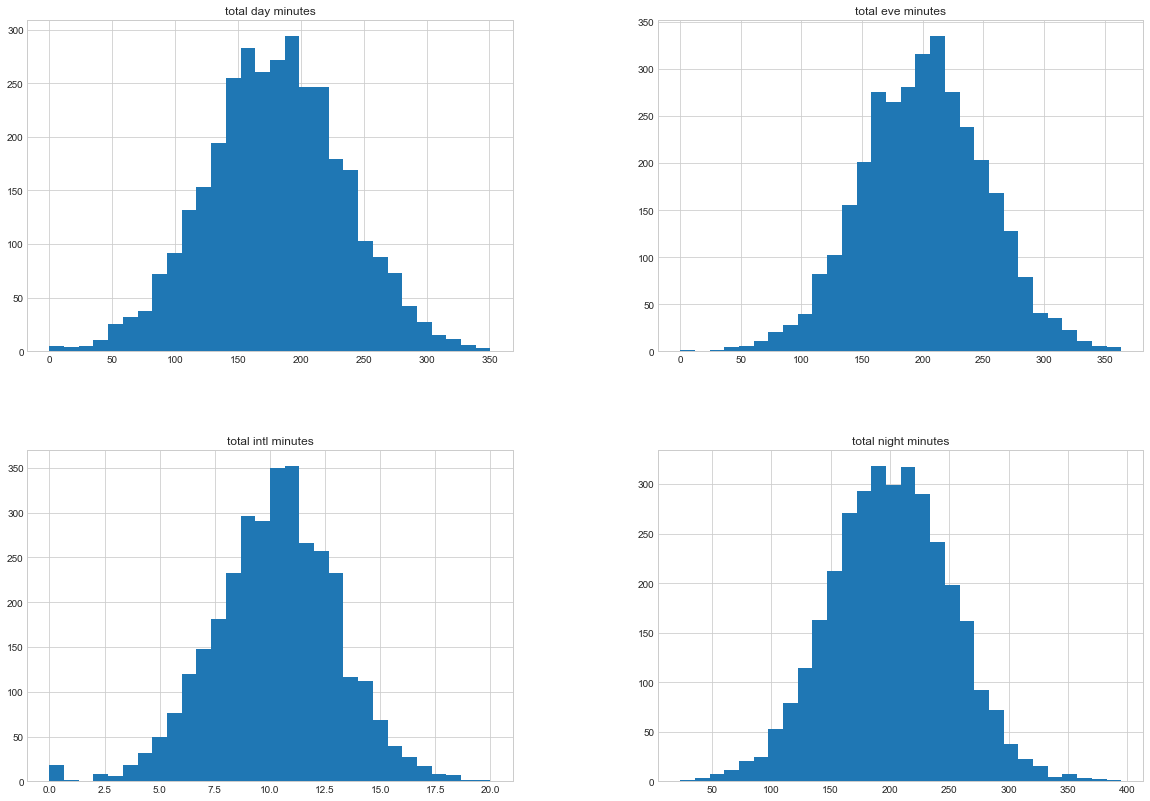

In [107]:
df[total_minutes].hist(bins=30, figsize=(20, 14))

In [102]:
# Observation: International calls are skewed to the right, meaning the mean of this feature is lower than the other three features.
# There's much fewer data representing international calls than its counter-parts.

total_calls = ['total day calls', 'total eve calls', 'total night calls', 'total intl calls']
df[total_calls].describe()

,total day calls,total eve calls,total night calls,total intl calls
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,100.435644,100.114311,100.107711,4.479448
std,20.069084,19.922625,19.568609,2.461214
min,0.000000,0.000000,33.000000,0.000000
25%,87.000000,87.000000,87.000000,3.000000
50%,101.000000,100.000000,100.000000,4.000000
75%,114.000000,114.000000,113.000000,6.000000
max,165.000000,170.000000,175.000000,20.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5ec6fa390>,
      dtype=object)

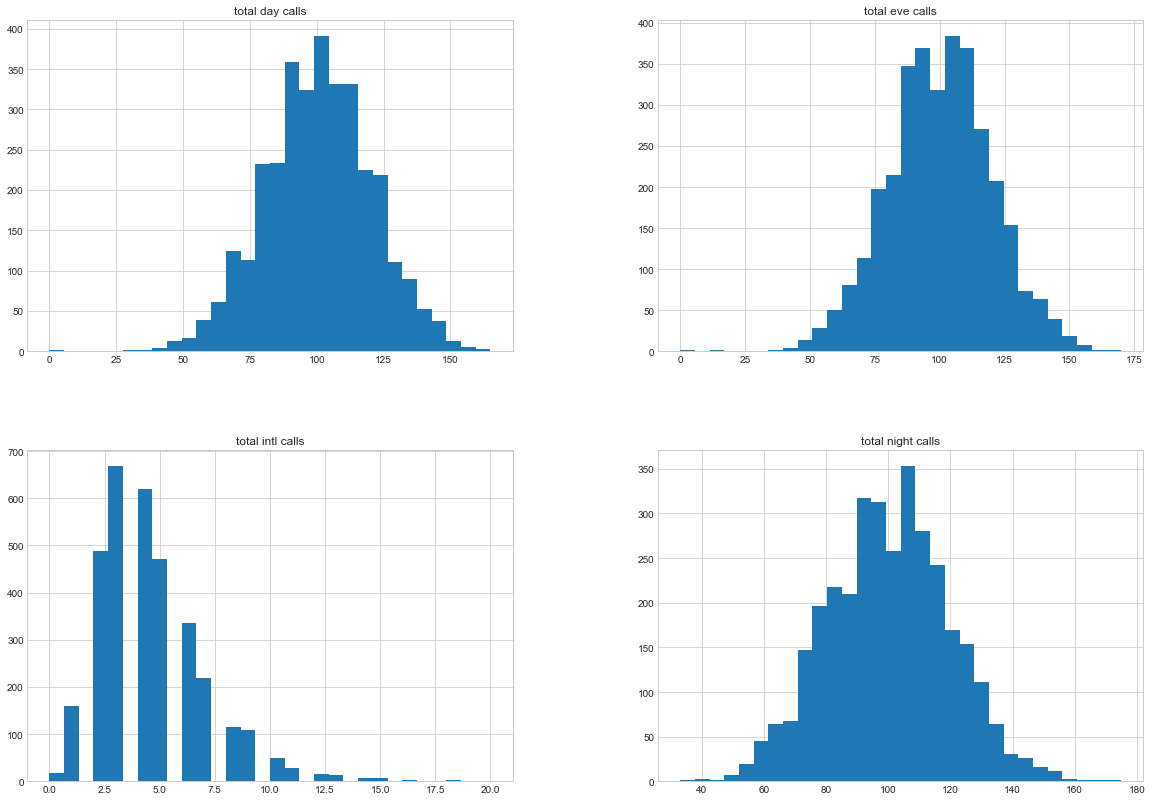

In [103]:
df[total_calls].hist(bins=30, figsize=(20, 14))

In [104]:
# Observation: normal distributions within these features
total_charges = ['total day charge', 'total eve charge', 'total night charge', 'total intl charge']
df[total_charges].describe()

,total day charge,total eve charge,total night charge,total intl charge
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,30.562307,17.083540,9.039325,2.764581
std,9.259435,4.310668,2.275873,0.753773
min,0.000000,0.000000,1.040000,0.000000
25%,24.430000,14.160000,7.520000,2.300000
50%,30.500000,17.120000,9.050000,2.780000
75%,36.790000,20.000000,10.590000,3.270000
max,59.640000,30.910000,17.770000,5.400000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d55f6860>,
      dtype=object)

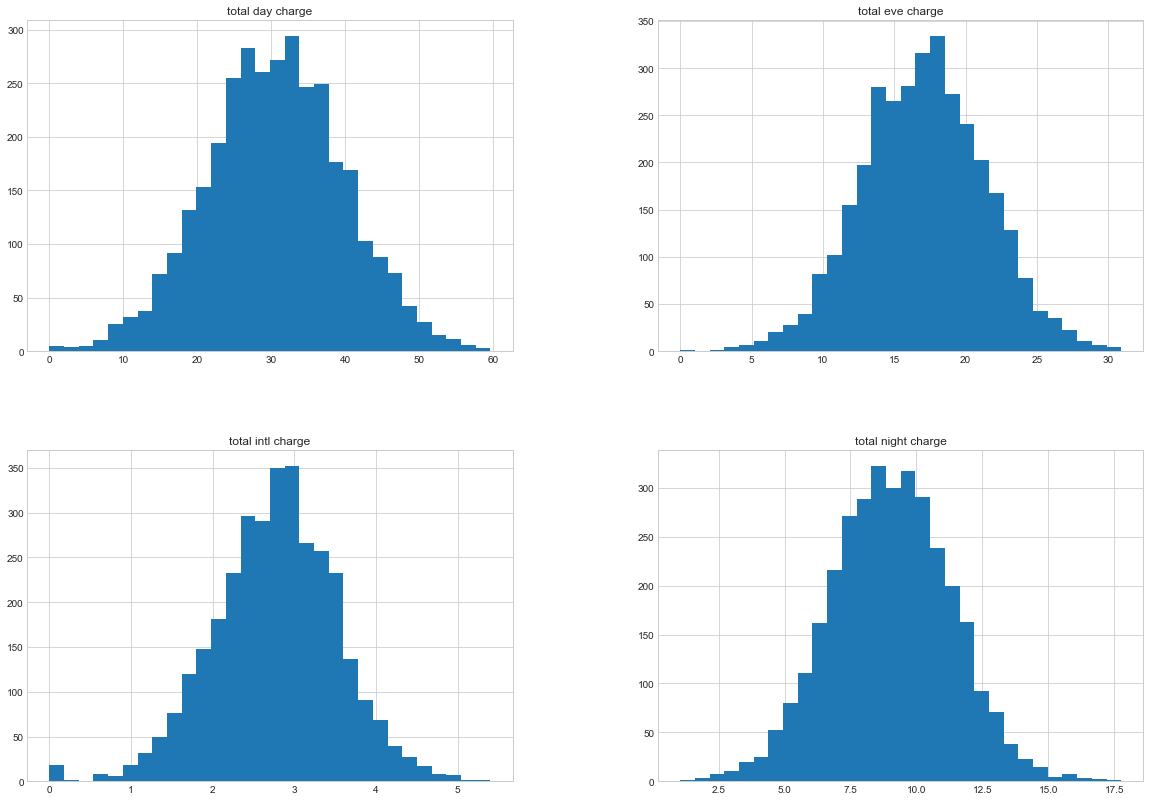

In [105]:
df[total_charges].hist(bins=30, figsize=(20, 14))

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

### Scatter Matrix

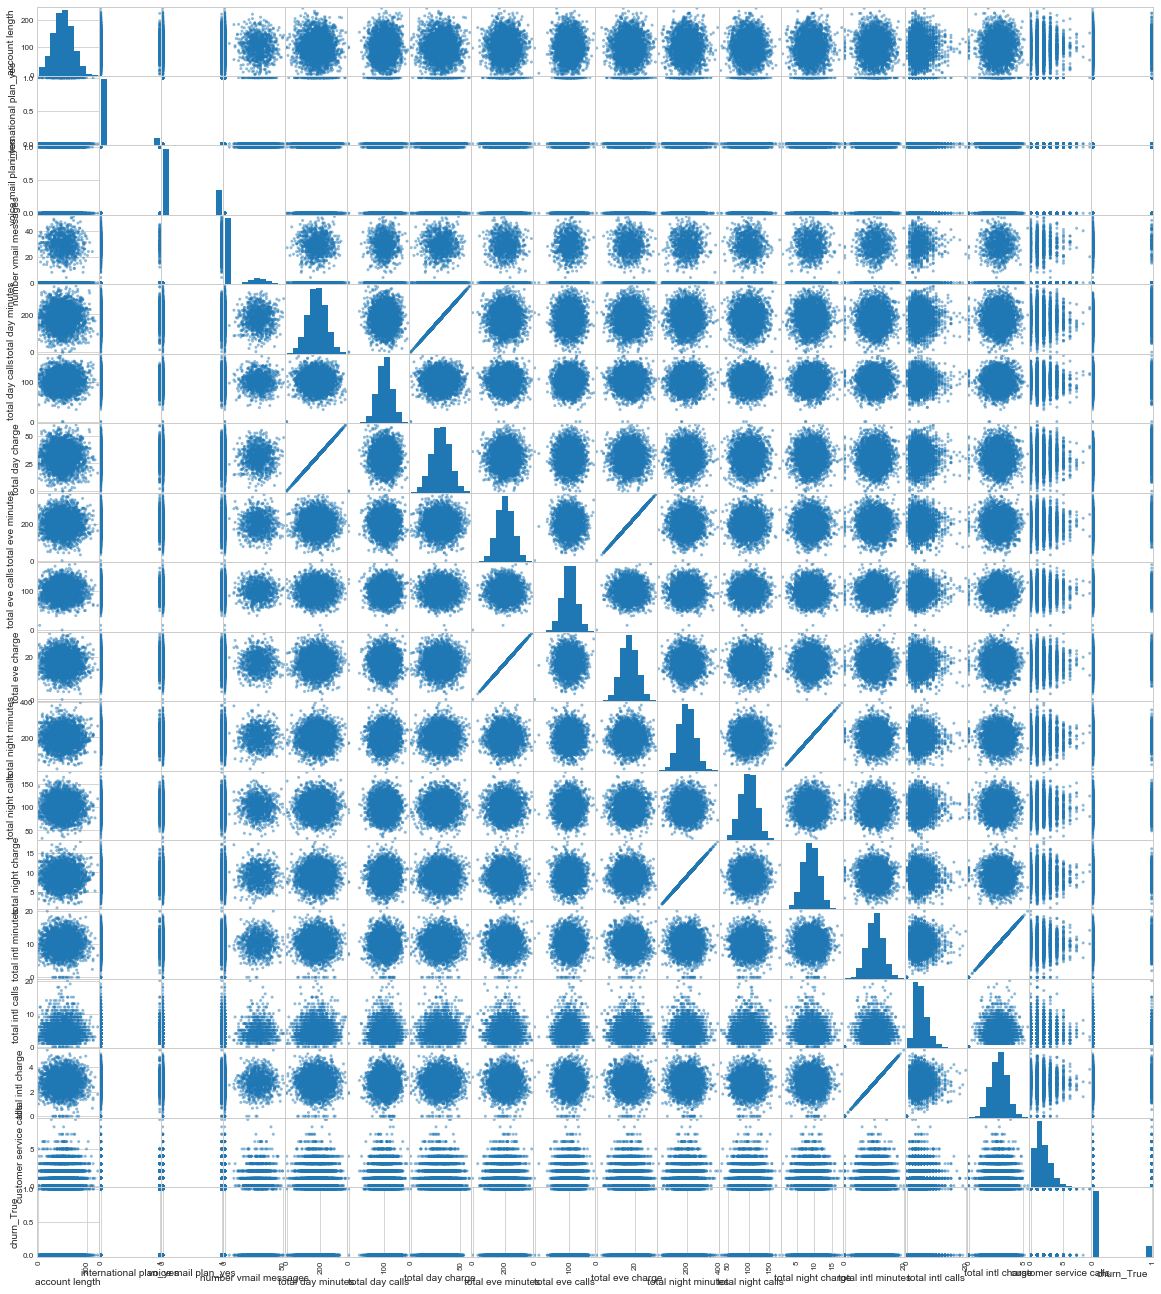

In [84]:
x_cols = ['account length', 'international plan_yes', 'voice mail plan_yes', 
          'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 
          'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 
          'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 
          'total intl charge', 'customer service calls', 'churn_True']

pd.plotting.scatter_matrix(df[x_cols], figsize=(20,23));


### Boxplot Analysis

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.096910,0.276628,0.144914
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.295879,0.447398,0.352067
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.000000,0.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,0.000000,0.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,1.000000,0.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,1.000000,1.000000


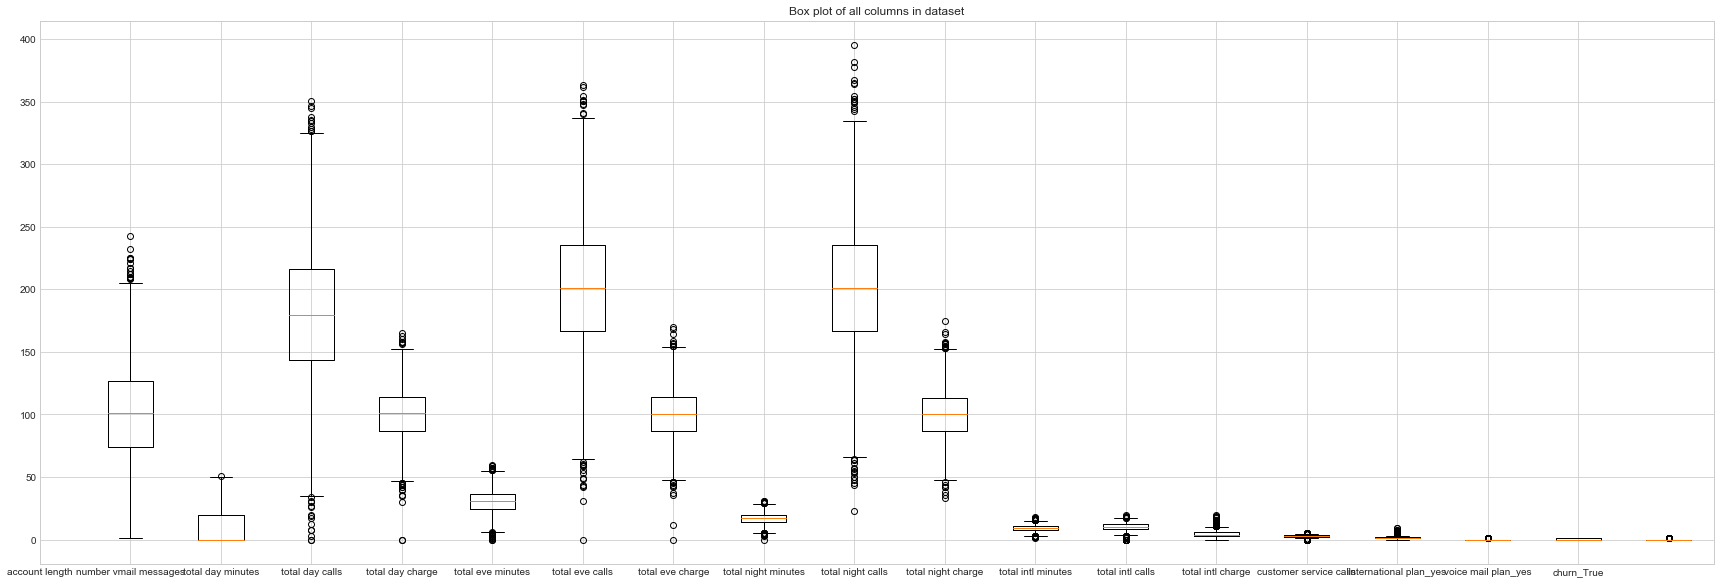

In [95]:
# Explore the dataset
display(df.describe())

# Create a box plot of each column
plt.figure(figsize=(30, 10))
plt.boxplot([df[col] for col in df.columns])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(len(df.columns.values)), df.columns.values)
plt.show()

### Heatmap

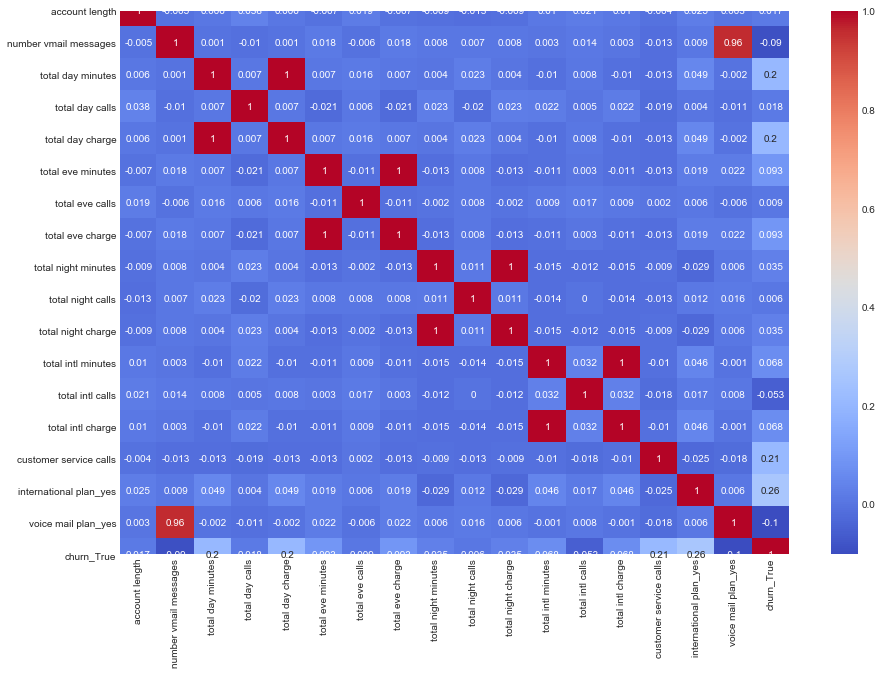

In [125]:
cor = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(cor.round(3),annot=True,cmap='coolwarm')
plt.show()

### Chi Squared Test

This test is used to compare the distribution of categories in a categorical feature of two or more groups; comparing if an attribute has a relationship to another categorical attribute.

In [128]:
df.columns

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes', 'churn_True'],
      dtype='object')

In [133]:
# I want to find out which categorical features are significant (pvalue < 0.05) to utilize in the 
# models for the future.

categories = ['international plan_yes', 'voice mail plan_yes']

y = df['churn_True']
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
for col in categories:
    xcat = LabelEncoder().fit_transform(df[col]).reshape(-1,1)
    cval,pval = chi2(xcat,y)
    print(col,pval)

international plan_yes [4.09173473e-46]
voice mail plan_yes [5.28486023e-07]


### ANOVA Test

ANOVA testing is utilized for comparing the distributions of numeric variables within two or more groups

In [134]:
df.columns

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes', 'churn_True'],
      dtype='object')

In [137]:
numericals = ['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls']
xnum = df[numericals]
y = df['churn_True']
from sklearn.feature_selection import f_classif
fval,pval = f_classif(xnum,y)
for i in range(len(numericals)):print(numericals[i],pval[i])

account length 0.33976000705720666
number vmail messages 2.1175218402696038e-07
total day minutes 5.300278227509361e-33
total day calls 0.28670102402211844
total day charge 5.30060595239102e-33
total eve minutes 8.011338561256927e-08
total eve calls 0.5941305829720491
total eve charge 8.036524227754477e-08
total night minutes 0.04046648463758881
total night calls 0.7230277872081609
total night charge 0.040451218769160205
total intl minutes 8.05731126549437e-05
total intl calls 0.002274701409850077
total intl charge 8.018753583047257e-05
customer service calls 3.900360240185746e-34


### Applying to ML algorithms

In [153]:
# Taking all significant features and consolodating them into the X-value with regards to my y-value

X = df[['total eve charge', 'total eve minutes', 'total day charge', 
       'number vmail messages', 'total day minutes', 'total night minutes', 
       'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 
       'international plan_yes', 'voice mail plan_yes']]
y = df['churn_True']

In [154]:
def print_results(headline, true_value, pred):
    print(headline)
    print('accuracy: {}'.format(accuracy_score(true_value, pred)))
    print('precision: {}'.format(precision_score(true_value, pred)))
    print('recall: {}'.format(recall_score(true_value, pred)))
    print('f1: {}'.format(f1_score(true_value, pred)))

In [156]:
# classifier to use     (can I use def to imput all 4 models here?)
classifier = RandomForestClassifier

# splitting data into trainning and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=1)

# building normal model
pipeline = make_pipeline(classifier(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [159]:
from sklearn.base import TransformerMixin

class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))

In [160]:
N = 5

rf = RandomForestClassifier(max_depth = N, n_estimators=100, n_jobs=-1, 
                            random_state=42,criterion = 'entropy', max_leaf_nodes = 2**N-1)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X, y)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

NameError: name 'OneHotEncoder' is not defined

In [157]:
# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# build model with undersampling
nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state=42), classifier(random_state=42))
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
      out_step='deprecated', random_state=4, ratio=None,
      sampling_strategy='auto', svm_estimator='deprecated')' (type <class 'imblearn.over_sampling._smote.SMOTE'>) doesn't

In [ ]:
# printing information about both models
print()
print('normal data distribution: {}'.format(Counter(df['target'])))
X-smote, y_smote = SMOTE().fit_sample(df['df'], df['target'])
print('SMOTE data distribution: {}'.format(Counter(y_smote)))
X_nearmiss, y_nearmiss = NearMiss().fitsample(df['df'], df['target'])
print('NearMiss data distribution: {}'.format(Counter(y_nearmiss)))

# Classification report
print(classification_report(y_test, prediction))
print(classification_report_imbalanced(y_test, smote_prediction))

print()
print('normal Pipeline Score {}'.format(pipeline.score(X_test, y_test)))
print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))

print()
print_results('normal classification', y_test, prediction)
print()
print_results('SMOTE classification', y_test, smote_prediction)
print()
print_results('NearMiss classification', y_test, nearmiss_prediction)


In [ ]:
from sklearn.model_selection import KFold

# cross validation done right
kf = KFold(n_splits=5, random_state=42)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
for train, test in kf.split(X_train, y_train):
    pipeline = make_pipeline_imb(SMOTE(), classifier(random_state=42))
    model = pipeline.fit(X_train[train], y_train[train])
    prediction = model.predict(X_train[test])

    accuracy.append(pipeline.score(X_train[test], y_train[test]))
    precision.append(precision_score(y_train[test], prediction))
    recall.append(recall_score(y_train[test], prediction))
    f1.append(f1_score(y_train[test], prediction))
    auc.append(roc_auc_score(y_train[test], prediction))

print()
print("done right mean of scores 5-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print()

# cross validation done wrong
kf = KFold(n_splits=5, random_state=42)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
X, y = SMOTE().fit_sample(X_train, y_train)
for train, test in kf.split(X, y):
    pipeline = make_pipeline(classifier(random_state=42))
    model = pipeline.fit(X[train], y[train])
    prediction = model.predict(X[test])

    accuracy.append(pipeline.score(X[test], y[test]))
    precision.append(precision_score(y[test], prediction))
    recall.append(recall_score(y[test], prediction))
    f1.append(f1_score(y[test], prediction))

print("done wrong mean of scores 5-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))